In [1]:
#!pip3 install -e .
import numpy as np
import matplotlib.pyplot as plt
from astropy import convolution
from astropy.io import fits
from scipy import signal
import emcee
from multiprocessing import Pool, get_context
from fit_ring import fit_ring

In [2]:
Band = "Band6"
#Band = "Band4"

ring = "inner"
#ring = "outer"

limit_theta = True
#limit_theta = False

width = "fiducial"
#width = "wide"

temperature = "fiducial"
#temperature = "high"

n_walker = 32
n_step = 10000

In [3]:
if Band == "Band6":
    hdulist = fits.open("../obs/hd163296_band6.fits")
    wavelength = 0.1254450233571054
    NCUT = 1000
    sigma = 0.18263960681950794 # noise level in Band 6 after smoothing. Before smoothing, noise level is 0.2585670770753724 K
    smooth_B6_image = True
    if ring == "inner":
        init = np.array([0.9, 1.2, 68.0, 0.7, 4.7, 4.1])
        #pos = np.array([0.9, 1.2, 68.0, 0.7, 4.7, 4.1])+  0.1* np.random.randn(n_walker, 6)
    elif ring == "outer":
        init = np.array([0.9, 1.2, 100.0, 0.3, 4.0, 1.0])
        #pos = np.array([0.9, 1.2, 100.0, 0.3, 4.0, 1.0])+  0.1* np.random.randn(n_walker, 6)
    else:
        raise ValueError("ring must be either inner or outer")
elif Band == "Band4":
    NCUT = 200
    hdulist = fits.open("../obs/hd163296_band4.fits")
    wavelength = 0.21416788052496163
    sigma = 0.1925369232259328
    smooth_B6_image = False
    if ring == "inner":
        init = np.array([0.9, 1.2, 68.0, 0.4, 4.7, 4.1])
        #pos = np.array([0.9, 1.2, 68.0, 0.4, 4.7, 4.1])+  0.1* np.random.randn(n_walker, 6)
    elif ring == "outer":
        init = np.array([0.9, 1.1, 100.0, 0.2, 4.0, 1.0])
        #pos = np.array([0.9, 1.1, 100.0, 0.2, 4.0, 1.0])+  0.1* np.random.randn(n_walker, 6)
    else:
        raise ValueError("ring must be either inner or outer")   
else:
    raise ValueError("Band must be either Band4 or Band6")

if ring == "inner":
    r_range = [60.0, 75.0]
    if width == "wider":
        r_range = [55.0, 80.0]
elif ring == "outer":
    r_range = [94.0, 106.0]
    if width == "wider":
        r_range = [90.0, 110.0]


temperature_t0 = 21.9
temperature_r0 = 100.0
temperature_pow = -0.5
if temperature == "high":
    temperature_t0 = 1000.0
    temperature_r0 = 100.0
    temperature_pow = 0.0
    if ring == "inner":
        if Band == "Band6":
            init = np.array([0.9, 1.2, 68.0, 0.01, 4.7, 4.1])
            #pos = np.array([0.9, 1.2, 68.0, 0.01, 4.7, 4.1])+  0.1* np.random.randn(n_walker, 6) * np.array([1.0, 1.0, 1.0, 1e-2, 1.0, 1.0])
        elif Band == "Band4":
            init = np.array([0.9, 1.2, 68.0, 0.01, 4.0, 1.0])
            #pos = np.array([0.9, 1.2, 68.0, 0.01, 4.0, 1.0])+  0.1* np.random.randn(n_walker, 6) * np.array([1.0, 1.0, 1.0, 1e-2, 1.0, 1.0])
    elif ring == "outer":
        if Band == "Band6":
            init = np.array([0.9, 1.2, 100.0, 0.01, 4.7, 4.1])
            #pos = np.array([0.9, 1.2, 100.0, 0.01, 4.7, 4.1])+  0.1* np.random.randn(n_walker, 6) * np.array([1.0, 1.0, 1.0, 1e-2, 1.0, 1.0])
        elif Band == "Band4":
            init = np.array([0.9, 1.1, 100.0, 0.01, 4.0, 1.0])
            #pos = np.array([0.9, 1.1, 100.0, 0.01, 4.0, 1.0])+  0.1* np.random.randn(n_walker, 6) * np.array([1.0, 1.0, 1.0, 1e-2, 1.0, 1.0])

# smooth B6 image to be the same beam size as B4
BMAJ_B6toB4 = 5.024359709644313
BMIN_B6toB4 = 3.4857659914758288 
BPA_B6toB4 = 144.70473062543104 #2.525573992625245/np.pi*180

BMAJ_B4 = 6.5696999281654325 
BMIN_B4 = 5.704718712715835 
BPA_B4 = -54.94570922852

BMAJ_B4_deproj = 8.35700508160625
BMIN_B4_deproj = 6.539130424457605
BPA_B4_deproj = 48.016490949755315

In [4]:
# distance
dis = 101.0 # pc
# disk geomertry
incl = 46.7/180*np.pi # inclination in degree
posang = 133.3/180*np.pi # position angle in degree
posang_proj = posang + np.pi/2

# read fits data
pic = hdulist[0]
header = pic.header
image = pic.data[0,0]
image = image[NCUT:-NCUT,NCUT:-NCUT] # cut emission free region

# check pixcel of figure
NAXIS1 = header['NAXIS1'] - NCUT*2
NAXIS2 = header['NAXIS2'] - NCUT*2
# check range (sec) per pixcel
CDELT1 = header['CDELT1']*3600
CDELT2 = header['CDELT2']*3600
CDELT1 = abs(CDELT1)
CDELT2 = abs(CDELT2)
BMAJ = header['BMAJ']*3600
BMIN = header['BMIN']*3600
BPA = header['BPA']

freqGHz = 29.9792458/wavelength
image = 1.222e6 * image/BMAJ/BMIN/freqGHz**2

noise_level = 1.234870664277e-5*1.222e6/BMAJ/BMIN/freqGHz**2
CDELT1 = CDELT1 * dis
CDELT2 = CDELT2 * dis
BMAJ = BMAJ * dis
BMIN = BMIN * dis

# smooth B6 image
if smooth_B6_image:
    beam_kernel_B6toB4 = convolution.Gaussian2DKernel(BMIN_B6toB4/2.355/CDELT2, BMAJ_B6toB4/2.355/CDELT1, theta=(BPA_B6toB4/180*np.pi)).array
    #image = convolution.convolve_fft(image, beam_kernel)
    image = signal.fftconvolve(image, beam_kernel_B6toB4, mode="same") # fastest
    print("smoothed the image")
else:
    print("the image is not smoothed")

smoothed the image


In [5]:
import scipy.interpolate as interpolate
# convert to radian
def deproject_image(image, ratio, pa_rad, nx0, ny0):
    nx, ny = image.shape
    # create coordinate system
    x = np.arange(nx)
    y = np.arange(ny)
    xx, yy = np.meshgrid(x, y, indexing="xy")
    # deproject
    dxx1 =  (xx-nx0)*np.cos(pa_rad) + (yy-ny0)*np.sin(pa_rad)
    dyy1 = -(xx-nx0)*np.sin(pa_rad) + (yy-ny0)*np.cos(pa_rad)
    dyy1 = dyy1 / ratio
    xx2 =  dxx1*np.cos(pa_rad) - dyy1*np.sin(pa_rad) + nx0
    yy2 = +dxx1*np.sin(pa_rad) + dyy1*np.cos(pa_rad) + ny0

    # interpolate image
    f = interpolate.RectBivariateSpline(np.arange(nx), np.arange(ny), image.T)
    image_deprojected = f.ev(xx2, yy2)
    return image_deprojected

def deproject_grid(xx, yy, ratio, pa_rad, x0=0, y0=0):
    # deproject
    dxx1 =  (xx-x0)*np.cos(pa_rad) + (yy-y0)*np.sin(pa_rad)
    dyy1 = -(xx-x0)*np.sin(pa_rad) + (yy-y0)*np.cos(pa_rad)
    dyy1 = dyy1 * ratio
    xx2 =  dxx1*np.cos(pa_rad) - dyy1*np.sin(pa_rad) + x0
    yy2 = +dxx1*np.sin(pa_rad) + dyy1*np.cos(pa_rad) + y0
    return xx2, yy2

# deproject all images
image_deproj = deproject_image(image, 1/np.cos(incl), posang_proj, (NAXIS1-1)/2, (NAXIS2-1)/2)

In [6]:
# make grid for observational ana
x_obs = np.linspace(-(NAXIS1-1)*CDELT1/2, (NAXIS1-1)*CDELT1/2, NAXIS1)
y_obs = np.linspace(-(NAXIS2-1)*CDELT2/2, (NAXIS2-1)*CDELT2/2, NAXIS2)
xx_obs, yy_obs = np.meshgrid(x_obs, y_obs, indexing='xy')

BMAJ_indep = BMAJ_B4_deproj
BMIN_indep = BMIN_B4_deproj
BAVE_indep = np.sqrt(BMAJ_indep*BMIN_indep)

n_grid_half = int(r_range[1]/BAVE_indep) + 1
x_data_point_deproj = (np.arange(-n_grid_half, n_grid_half)+0.5) * BAVE_indep
y_data_point_deproj = (np.arange(-n_grid_half, n_grid_half)+0.5) * BAVE_indep
xx_data_point_deproj, yy_data_point_deproj = np.meshgrid(x_data_point_deproj, y_data_point_deproj, indexing='xy')
xx_data_point_deproj = xx_data_point_deproj.flatten()
yy_data_point_deproj = yy_data_point_deproj.flatten()

# deproject grid
xx_data_point, yy_data_point = deproject_grid(xx_data_point_deproj, yy_data_point_deproj, np.cos(incl), posang_proj)
rr_data_point = np.sqrt(xx_data_point_deproj**2 + yy_data_point_deproj**2)
theta_data_point = np.arctan2(yy_data_point_deproj, xx_data_point_deproj)

# choose data points to fit
xx_data_point, yy_data_point = xx_data_point[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])], yy_data_point[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
xx_data_point_deproj, yy_data_point_deproj = xx_data_point_deproj[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])], yy_data_point_deproj[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
if (limit_theta):
    xx_data_point, yy_data_point = xx_data_point[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)], yy_data_point[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)]
    xx_data_point_deproj, yy_data_point_deproj = xx_data_point_deproj[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)], yy_data_point_deproj[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)]

n_data_point = len(xx_data_point)

In [7]:
x_model_deproj = np.linspace(-119.5, 119.5, 240)
y_model_deproj = np.linspace(-119.5, 119.5, 240)
xx_model_deproj, yy_model_deproj  = np.meshgrid(x_model_deproj, y_model_deproj, indexing="xy")

# deproject grid
xx_model, yy_model = deproject_grid(xx_model_deproj, yy_model_deproj, np.cos(incl), posang_proj)

bmaj_model = BMAJ_B4_deproj
bmin_model = BMIN_B4_deproj
bpa_model = BPA_B4_deproj
dx = x_model_deproj[1] - x_model_deproj[0]
dy = y_model_deproj[1] - y_model_deproj[0]
bmaj_model_n = bmaj_model / dx
bmin_model_n = bmin_model / dx

beam_kernel = convolution.Gaussian2DKernel(bmin_model_n/2.355, bmaj_model_n/2.355, bpa_model/180*np.pi).array

In [8]:
def log_likelihood(params, sigma):
    xcen, ycen, ring_r0, ring_tau, ring_w, ring_h = params
    xx_data_point_deproj_cen = xx_data_point_deproj + xcen
    yy_data_point_deproj_cen = yy_data_point_deproj + ycen
    obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image_deproj.T, xx_data_point_deproj_cen, yy_data_point_deproj_cen)
    intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model_deproj, yy_model_deproj)
    #intensity_conv = fit_ring.convolution(intensity, beam_kernel)
    intensity_conv = signal.fftconvolve(intensity, beam_kernel, mode="same")
    model_data_points = fit_ring.interpolate_data(x_model_deproj, y_model_deproj, intensity_conv.T, xx_data_point_deproj, yy_data_point_deproj)
    chi2 = np.sum((obs_data_points - model_data_points)**2)/sigma**2
    return -0.5 * chi2

def log_prior(params):
    xcen, ycen, ring_r0, ring_tau, ring_w, ring_h = params
    if 0.0<=ring_tau and 0.0<=ring_w and 0.0<=ring_h:
        return 0.0
    return -np.inf

def log_probability(params, sigma):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, sigma)

2.3265238929084413

In [9]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
#initial = np.array([0.9, 1.2, 68.0, 0.7, 4.7, 4.1])
soln = minimize(nll, init, args=(sigma))
results = abs(soln.x)
print(results)

KeyboardInterrupt: 

In [ ]:
pos = results + 0.01 * np.random.randn(n_walker, 6)
pos = abs(pos)
nwalkers, ndim = pos.shape

with get_context("fork").Pool() as pool: # for M1 Mac
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=([sigma]), pool=pool)
    sampler.run_mcmc(pos, n_step, progress=True)

100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]


In [ ]:
# if limit_theta = False, then the filename is Band + "_" + ring + "_no_limit_theta"
filename = Band + "_" + ring
if (limit_theta == False):
    filename = filename + "_full"

if (width == "wide"):
    filename = filename + "_wide"

(528, 6)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/var/folders/5j/qvxhwrf527z0xqyzz4b8skhm0000gn/T/ipykernel_50396/3568412060.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig("../output/" + filename + "_corner.pdf", rasterized=True)


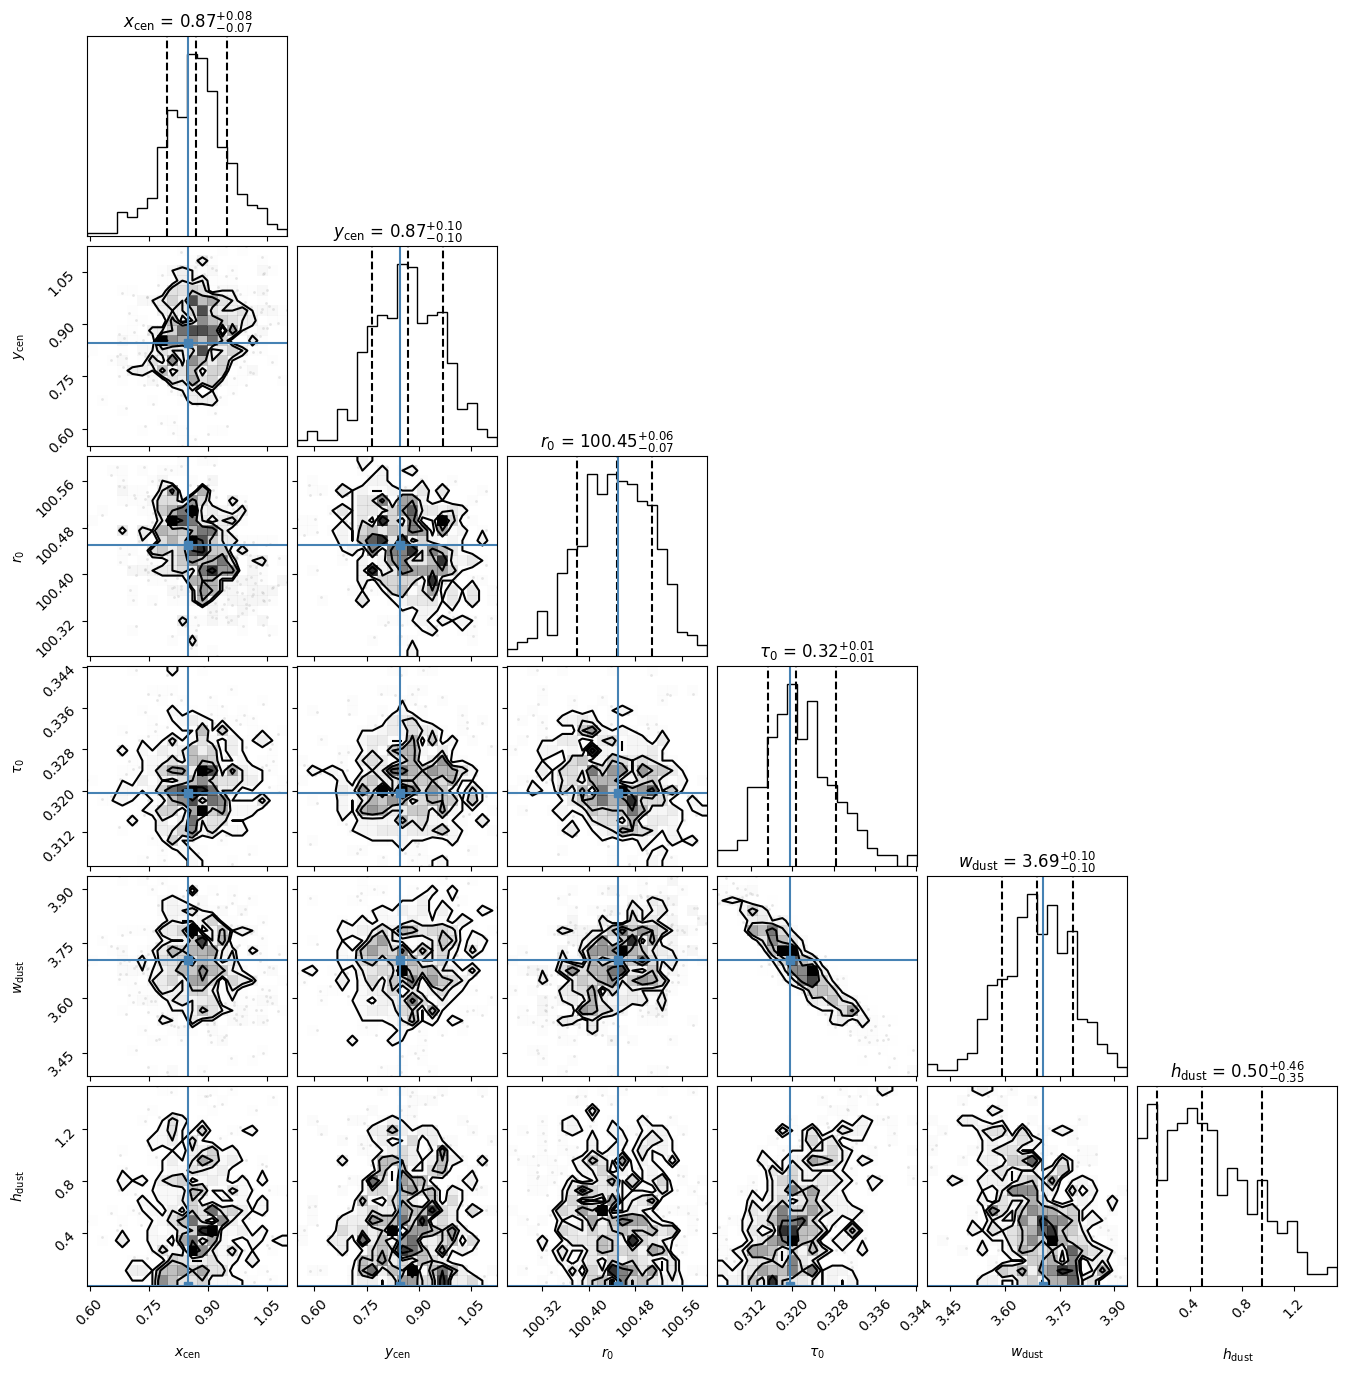

In [ ]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)
import corner

from IPython.display import display, Math

labels = ["$x_{\mathrm{cen}}$", "$y_{\mathrm{cen}}$", "$r_0$", r"$\tau_0$", "$w_{\mathrm{dust}}$", "$h_{\mathrm{dust}}$"]


mcmc = np.zeros((ndim, 3))
q = np.zeros((ndim, 2))
for i in range(ndim):
    mcmc[i,:] = np.percentile(flat_samples[:, i], [16, 50, 84])
    q[i,:] = np.diff(mcmc[i,:])
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[i, 1], q[i, 0], q[i, 1], labels[i])
    display(Math(txt))


#labels = ["xcen", "ycen", "ring_r0", "ring_tau", "ring_w", "ring_h"]

fig = corner.corner(
    flat_samples, 
    labels=labels, 
    truths=list(results), 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
)

fig.savefig("../output/" + filename + "_corner.pdf", rasterized=True)

In [ ]:
corner.corner?

Signature:
corner.corner(
    data,
    bins=20,
    *,
    range=None,
    weights=None,
    color='k',
    hist_bin_factor=1,
    smooth=None,
    smooth1d=None,
    labels=None,
    label_kwargs=None,
    titles=None,
    show_titles=False,
    title_fmt='.2f',
    title_kwargs=None,
    truths=None,
    truth_color='#4682b4',
    scale_hist=False,
    quantiles=None,
    verbose=False,
    fig=None,
    max_n_ticks=5,
    top_ticks=False,
    use_math_text=False,
    reverse=False,
    labelpad=0.0,
    hist_kwargs=None,
    group='posterior',
    var_names=None,
    filter_vars=None,
    coords=None,
    divergences=False,
    divergences_kwargs=None,
    labeller=None,
    **hist2d_kwargs,
)
Docstring:
Make a *sick* corner plot showing the projections of a data set in a
multi-dimensional space. kwargs are passed to hist2d() or used for
`matplotlib` styling.

Parameters
----------
data : obj
    Any object that can be converted to an ``arviz.InferenceData`` object.
    Refer to do

In [ ]:
# save mcmc result
#"../output/" + filename + "_value.csv"
mcmc_val = np.zeros((ndim, 4))
mcmc_val[:,0:3] = mcmc
mcmc_val[:,3] = results
np.savetxt("../output/" + filename + "_value.csv", mcmc_val, delimiter=",")

In [ ]:
mean_acceptance_fraction = np.mean(sampler.acceptance_fraction)
print("Mean acceptance fraction: {0:.3f}".format(mean_acceptance_fraction))

try: 
    tau = sampler.get_autocorr_time()
except:
    print("Autocorrelation time cannot be estimated")
    tau = np.inf

Mean acceptance fraction: 0.498
Autocorrelation time cannot be estimated


In [ ]:
# write summary
# fitted results, number of walkers, number of steps, mean acceptance fraction, autocorrelation time, filename
log_prob = log_probability(abs(results), sigma)
with open("../output/summary.csv", "a") as f:
    f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n".format(results[0], results[1], results[2], results[3], results[4], results[5], nwalkers, n_step, log_prob*(-2), n_data_point, log_prob*(-2)/n_data_point, mean_acceptance_fraction, tau, filename))

In [ ]:
raise Exception("Stop here")

Exception: Stop here

In [ ]:
plt.imshow(image, origin='lower')

In [ ]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(labels[i], mcmc[1], q[0], q[1])

In [ ]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(labels[i], mcmc)

In [ ]:
x1, x2, ring_r0, ring_tau, ring_w, ring_h = 0.9420525547875308, 1.1911604647674632, 67.7554665975438, 0.7511038609565008, 4.562632473038108, 4.18722700247981

xx_data_point_cen = xx_data_point + x1
yy_data_point_cen = yy_data_point + x2
obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image.T, xx_data_point_cen, yy_data_point_cen)

intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model_incl, yy_model_incl)
#intensity_conv = fit_ring.convolution(intensity, beam_kernel)
intensity_conv = signal.fftconvolve(intensity, beam_kernel, mode="same")
model_data_points = fit_ring.interpolate_data(x_model_deproj, y_model_deproj, intensity_conv.T, xx_data_point, yy_data_point)
obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image.T, xx_data_point, yy_data_point)

In [ ]:

# with colorbar
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(141)
im1 = ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(142)
im2 = ax2.imshow(intensity, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(143)
im3 = ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points, cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im3, ax=ax3)
ax3.axis('equal')
ax4 = fig.add_subplot(144)
im4 = ax4.scatter(xx_data_point, yy_data_point, c=model_data_points, cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im4, ax=ax4)
ax4.axis('equal')

In [ ]:
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(141)
im1 = ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(142)
im2 = ax2.imshow(intensity, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(143)

# blue to red
im3 = ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points-model_data_points, cmap="bwr", vmin = -2, vmax = 2)
fig.colorbar(im3, ax=ax3)
ax3.axis('equal')
ax4 = fig.add_subplot(144)
im4 = ax4.scatter(xx_data_point, yy_data_point, c=model_data_points, cmap="inferno", vmin = 0, vmax = 10)
fig.colorbar(im4, ax=ax4)
ax4.axis('equal')

In [ ]:
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(131)
ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax2 = fig.add_subplot(132)
ax2.imshow(intensity, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax3 = fig.add_subplot(133)
ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points, cmap="inferno", vmin = 0, vmax = 10)
ax3.axis('equal')

In [ ]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

ValueError: Dimension mismatch between samples and range

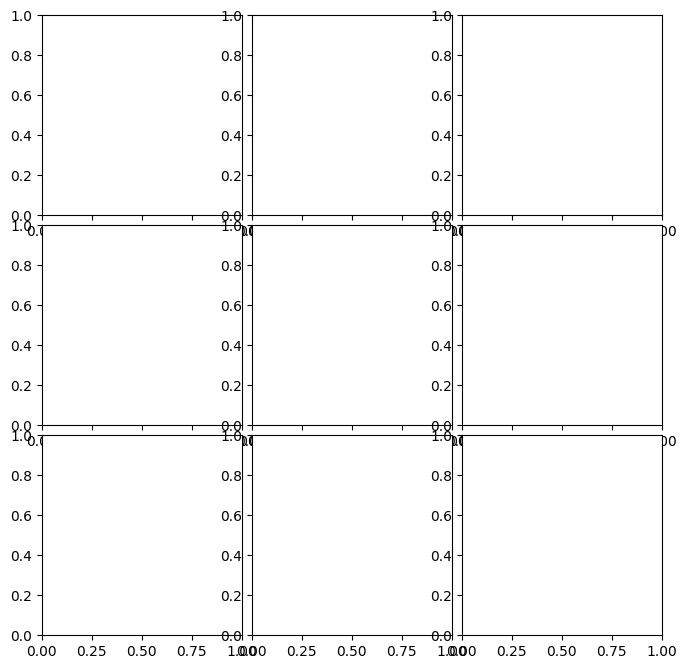

In [ ]:
samples = np.random.randn(1000, 3)
samples[np.random.rand(*samples.shape) < 0.1] = np.nan
samples[np.isnan(samples)] = 1000 # magic number
corner.corner(samples, range=[]);

In [ ]:
corner.corner?

Signature:
corner.corner(
    data,
    bins=20,
    *,
    range=None,
    weights=None,
    color='k',
    hist_bin_factor=1,
    smooth=None,
    smooth1d=None,
    labels=None,
    label_kwargs=None,
    titles=None,
    show_titles=False,
    title_fmt='.2f',
    title_kwargs=None,
    truths=None,
    truth_color='#4682b4',
    scale_hist=False,
    quantiles=None,
    verbose=False,
    fig=None,
    max_n_ticks=5,
    top_ticks=False,
    use_math_text=False,
    reverse=False,
    labelpad=0.0,
    hist_kwargs=None,
    group='posterior',
    var_names=None,
    filter_vars=None,
    coords=None,
    divergences=False,
    divergences_kwargs=None,
    labeller=None,
    **hist2d_kwargs,
)
Docstring:
Make a *sick* corner plot showing the projections of a data set in a
multi-dimensional space. kwargs are passed to hist2d() or used for
`matplotlib` styling.

Parameters
----------
data : obj
    Any object that can be converted to an ``arviz.InferenceData`` object.
    Refer to do

In [23]:
ring_r0 = 100.0
ring_tau = 0.5
ring_w = 4.0
ring_h = 4.0

posang = 80/180*np.pi

intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model_deproj, yy_model_deproj)

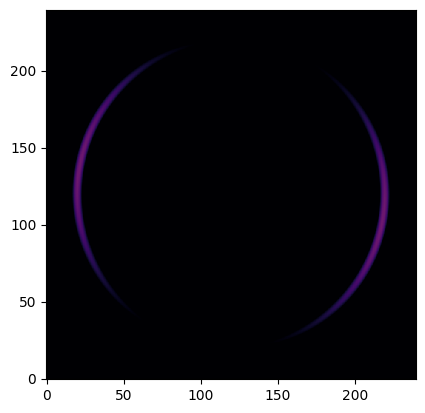

In [24]:
plt.imshow(intensity, origin="lower", cmap="inferno", vmin = 5, vmax = 10)

In [20]:
posang

0.5235987755982988